# Active Learning 
## Dr. Omri Allouche 
(omri.allouche@gmail.com)
## Active Learning for Image Classification - the MNIST Dataset
In this notebook, we'll review the use of Active Learning for improving the performance of models on the MNIST dataset. 

In [26]:
# Import relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (24,16)
plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["figure.titlesize"] = 50

In [2]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score

## Load Data
Let's first load the data. We'll use the popular MNIST digits dataset.  
It contains 70,000 images of size 28x28 pixels (reshaped into a 1D vector with 784 elements), of hand-written digits.

We first download the data using the `sklearn.datasets.fetch_mldata` function. 

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X = mnist.data
dim = int(np.sqrt(len(X[0]))) # equals 28
y = mnist.target

In [4]:
print(X.shape)
print(y.shape)
print(dim)

(70000, 784)
(70000,)
28


In [5]:
# Randomly shuffle two variables
def unison_shuffled_copies(a, b, max_size=None):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    if max_size is not None:
        p = p[:max_size]
    return a[p], b[p]

In [6]:
DATASET_SIZE = 10000
X, y = unison_shuffled_copies(X, y, max_size=DATASET_SIZE)

### Display Images
Let's display a sample image:

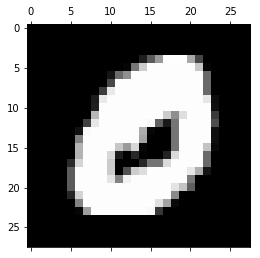

In [7]:
def plot_digit(id):
    plt.gray() 
    plt.matshow(X[id].reshape(dim,dim)) 
    plt.show() 
    
plot_digit(0)

In [8]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: 
        titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 1:
            image = image.reshape(dim,dim)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title, fontsize=50)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

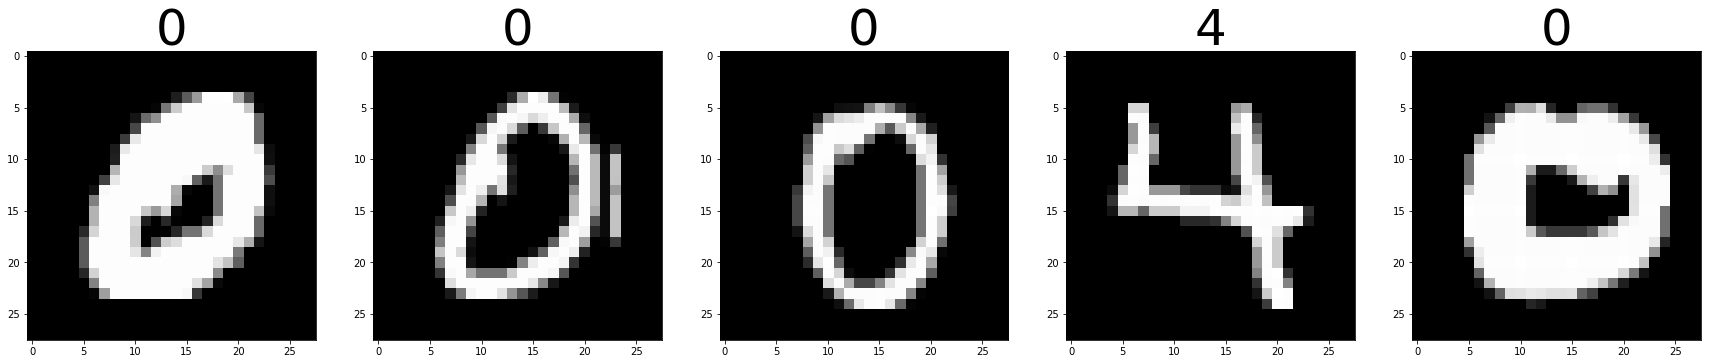

In [9]:
show_images([X[i] for i in range(5)], titles=[int(y[i]) for i in range(5)])

## Train a Basic Model
We'll train a basic Logistic Regression model on the data.  
Logistic Regression models in sklearn also report their assigned probability for each class, using the `predict_proba()` method.

First, let's split data into a train and test set:

In [10]:
from sklearn.model_selection import train_test_split
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [11]:
X_train.shape

(8000, 784)

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=50. / len(X_train),
                     multi_class='multinomial',
                     penalty='l1', solver='saga', tol=0.1)

model = svm.SVC(kernel='rbf', class_weight='balanced')

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

We now sort the images according to the probablity assigned to the predicted class (ie the maximal probablity for any of the classes).  
Note that since we have 10 classes, the minimal prediction probability is 0.1.  

In [13]:
predictions = model.predict(X_test)
predicted_probabilities = np.max(model.predict_proba(X_test), axis=1)
sorted_predicted_probabilities_indices = np.argsort(predicted_probabilities)

### Model Performance
Now print the classification report for the training set, using Sklearn's `classification_report` function:

In [40]:
print(classification_report(y_true=y_train,y_pred=model.predict(X_train)))

             precision    recall  f1-score   support

        0.0       0.94      0.91      0.92       774
        1.0       0.90      0.94      0.92       973
        2.0       0.88      0.83      0.85       772
        3.0       0.81      0.82      0.81       787
        4.0       0.85      0.75      0.80       807
        5.0       0.89      0.71      0.79       719
        6.0       0.88      0.92      0.90       774
        7.0       0.93      0.84      0.88       817
        8.0       0.66      0.79      0.72       772
        9.0       0.72      0.84      0.77       805

avg / total       0.85      0.84      0.84      8000



And the classification report for the test set:

In [41]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.95      0.92      0.93       215
        1.0       0.88      0.95      0.91       220
        2.0       0.89      0.86      0.88       207
        3.0       0.77      0.79      0.78       201
        4.0       0.79      0.72      0.76       184
        5.0       0.86      0.64      0.74       199
        6.0       0.88      0.90      0.89       185
        7.0       0.97      0.86      0.91       224
        8.0       0.58      0.75      0.65       176
        9.0       0.71      0.81      0.76       189

avg / total       0.84      0.82      0.83      2000



and finally, the f1 score on the test set using `macro` averaging:

In [42]:
print(f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro'))

0.8208029249588293


### Model Confidence, based on predicted probabilities

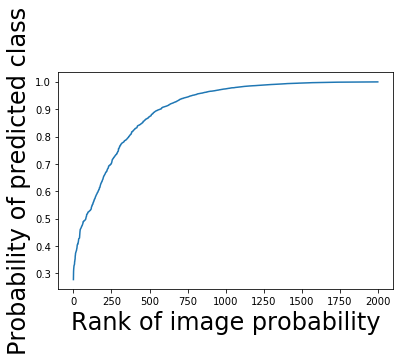

In [17]:
plt.plot(sorted(predicted_probabilities))
plt.xlabel('Rank of image probability')
plt.ylabel('Probability of predicted class');

Now let's display the images with the highest confidence, along with their predicted class in the title:

In [51]:
images = [X_test[x] for x in sorted_predicted_probabilities_indices[-9:]]
show_images(images, cols=3, titles=[int(v) for v in model.predict(images)])

and the images with the lowest confidence. We can see that these images seem harder, and the model makes more mistakes in their classification.

In [52]:
images = [X_test[x] for x in sorted_predicted_probabilities_indices[:9]]
show_images(images, cols=3, titles=[int(v) for v in model.predict(images)])

### Is the model confidence correlated with its performance?
Now, let's examine the model's performance as a function of its confidence (ie the probability it assigns to the predicted class).  
We first get predictions on the test set, and save whether they are correct or not.  
We then use Seaborn's `regplot` to plot average performance, using `x_bins=20`.

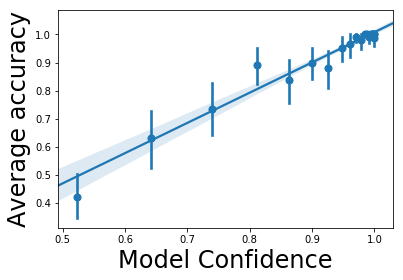

In [18]:
is_correct = y_test == model.predict(X_test)
ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=20)
plt.xlabel('Model Confidence')
plt.ylabel('Average accuracy')
# ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=np.arange(0.1,1,.1))

As we can see, our model is pretty aware of its performance - it performs well when its confidence is high, and makes more mistakes when his confidence is low.

This serves as a trigger for Active Learning.

### Visualizing Data and Model Confidence
In this section, we'll visualize our data and model confidence in 2D.  
We're interested in seeing where the points of low confidence lie.

First we load the PCAN and tSNE modules:

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Now, first run PCA with 10 components, and then tSNE with 2.  
For tSNE, use `perplexity` of 40 with `n_iter` set to 300.  
We'll use the `fit_transform` method of both classes.

In [55]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_pca)

Next, we'll get the model's confidence for the entire dataset:

In [56]:
predicted_probabilities_full = np.max(model.predict_proba(X), axis=1)
sorted_predicted_probabilities_full_indices = np.argsort(predicted_probabilities_full)

Let's plot a tSNE transformation of points to 2D, with colors indicating the predicted classes.

On top of it, we'll plot the confidence for each instance. We expect instances at the borders of class clusters to have a lower confidence.

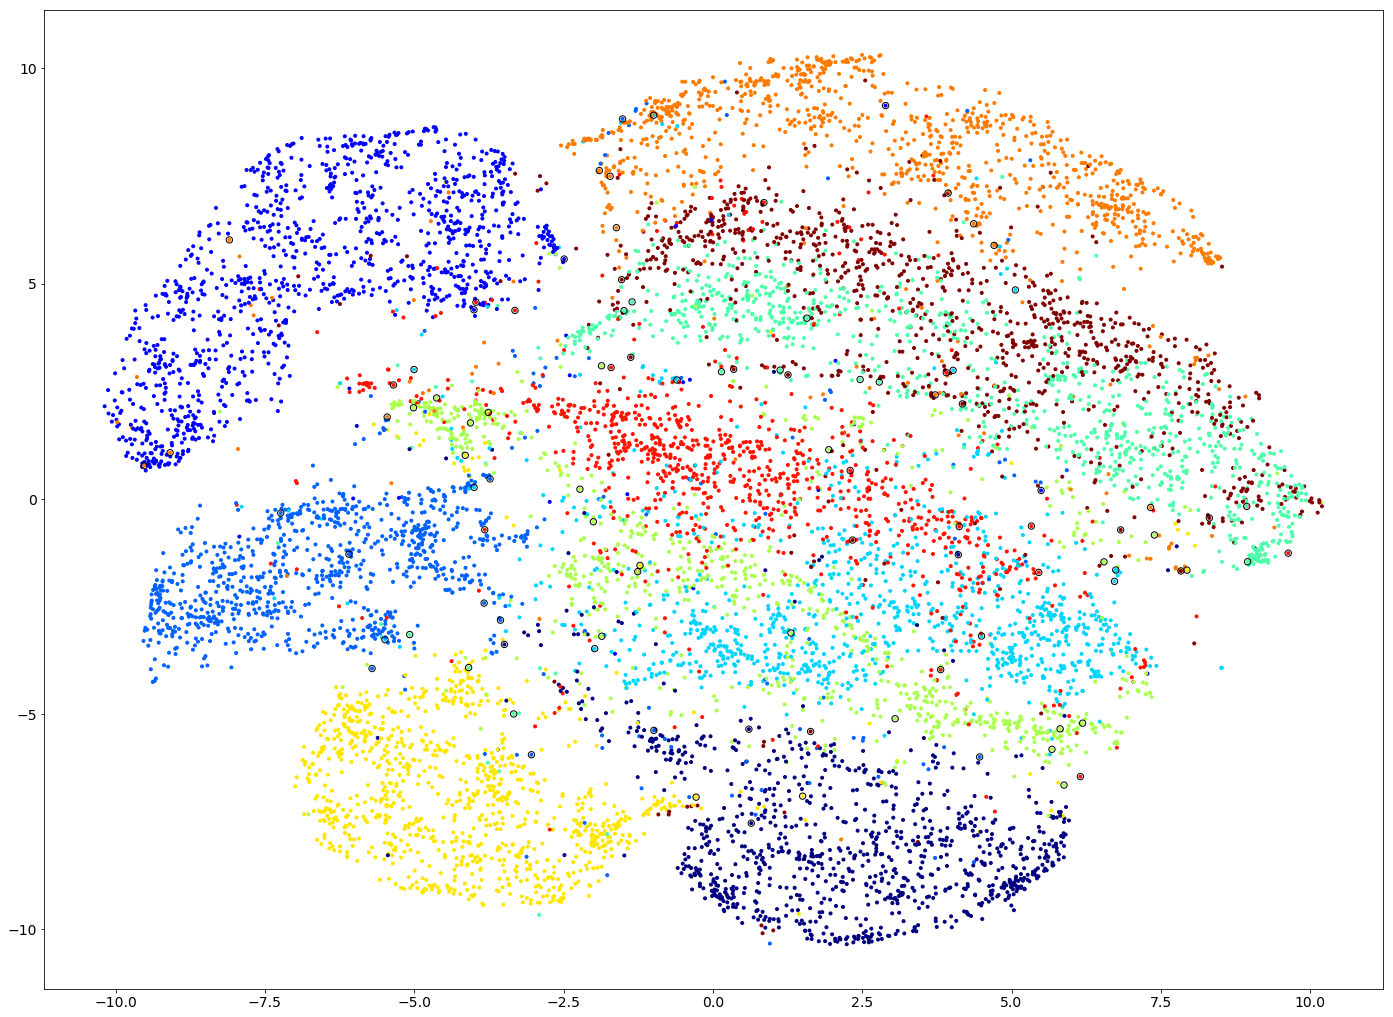

In [57]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=y, marker=".", cmap="jet")

low_conf = sorted_predicted_probabilities_full_indices[:100]
plt.scatter(tsne_results[low_conf, 0], tsne_results[low_conf, 1], s=40, facecolors='none', edgecolors='k')

We can also see this pattern by plotting the confidence level of the model:

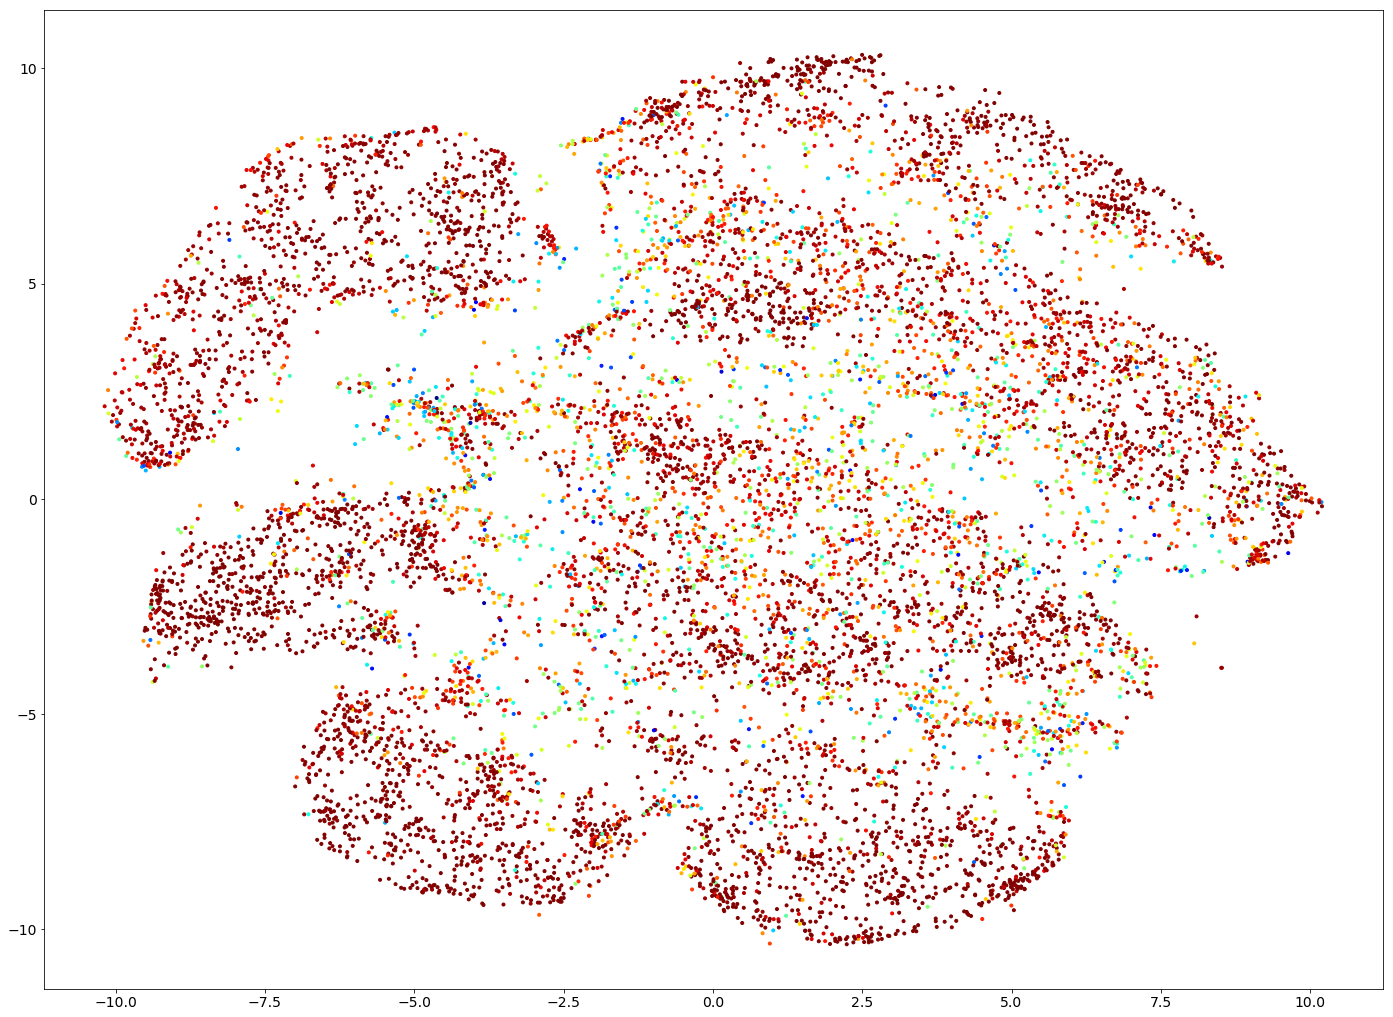

In [58]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=predicted_probabilities_full, marker=".", cmap="jet")

## Disagreement between models
In this section, we check the hypothesis that disagreement between different models is correlated with reduced model performance.  

We'll fit several models on our training set:
1. Logistic Regression
1. KNN (K=3)
1. KNN (K=7)
1. SVM (RBF kernel)
1. SVM (5th degree polynomial)

In [59]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors  import KNeighborsClassifier

models = [
    ('LR', LogisticRegression(C=1, multi_class='multinomial', penalty='l1', solver='saga', tol=0.1)),
    ('KNN3', KNeighborsClassifier(n_neighbors=3)),
    ('KNN7', KNeighborsClassifier(n_neighbors=7)),
    ('SVM_RBF', svm.SVC(kernel='rbf', class_weight='balanced')),
    ('SVM_poly5', svm.SVC(kernel='poly', degree=5, class_weight='balanced')),
]

In [27]:
models_predictions = pd.DataFrame()
for model_name, new_model in models:
    print("Running model {}...".format(model_name))
    models_predictions[model_name] = new_model.fit(X, y).predict(X)

Running model LR...
Running model KNN3...
Running model KNN7...
Running model SVM_RBF...
Running model SVM_poly5...


In [28]:
model_columns = models_predictions.columns
for i,r in models_predictions.iterrows():
    hist = r[model_columns].value_counts()
    models_predictions.loc[i,'confidence'] = hist.iloc[0] / len(models)
    models_predictions.loc[i,'prediction'] = hist.index[0]

Let's first review the resulting dataframe:

In [29]:
models_predictions.head()

,LR,KNN3,KNN7,SVM_RBF,SVM_poly5,confidence,prediction
0,3.0,3.0,3.0,3.0,3.0,1.0,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6.0,6.0,6.0,6.0,6.0,1.0,6.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,8.0,8.0,8.0,8.0,8.0,1.0,8.0


and plot our 2D tSNE projection, this time with the color indicating the level of agreement between our different models:

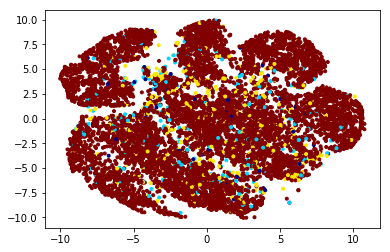

In [30]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=models_predictions['confidence'], marker=".", cmap="jet")

## Learning Curve
Let's plot the learning curve of the classifier - its performance based on the number of samples labeled.  

Each time, we take a subset of the train dataset, and use only it to train the model.  
We then calculate performance on the test set (that's left intact).  
We append the results of each run into a `history` variable.

In [47]:
model = model2

In [48]:
train_set_size_list = [10,20,30,40,50,75,100,150,200,250,300,350,400,450] + list(np.arange(500,1500,100)) + list(np.arange(1700,5000,250)) + list(np.arange(5500,10000,500))
history = []

for train_set_size in train_set_size_list:
    model = LogisticRegression(C=50. / len(X_train),
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)

    labeled_instances = X_train[:train_set_size]
    y_labeled_instances = y_train[:train_set_size]
    model.fit(labeled_instances, y_labeled_instances)
    
    history.append({"num_labels": len(labeled_instances),
                "labels": labeled_instances,
                "model": model,
                "accuracy_labeled_instances": accuracy_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances)),
                "f1_labeled_instances": f1_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances), average='macro'),
                "accuracy": accuracy_score(y_true=y_test,y_pred=model.predict(X_test)),
                "f1": f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro'),
               })


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


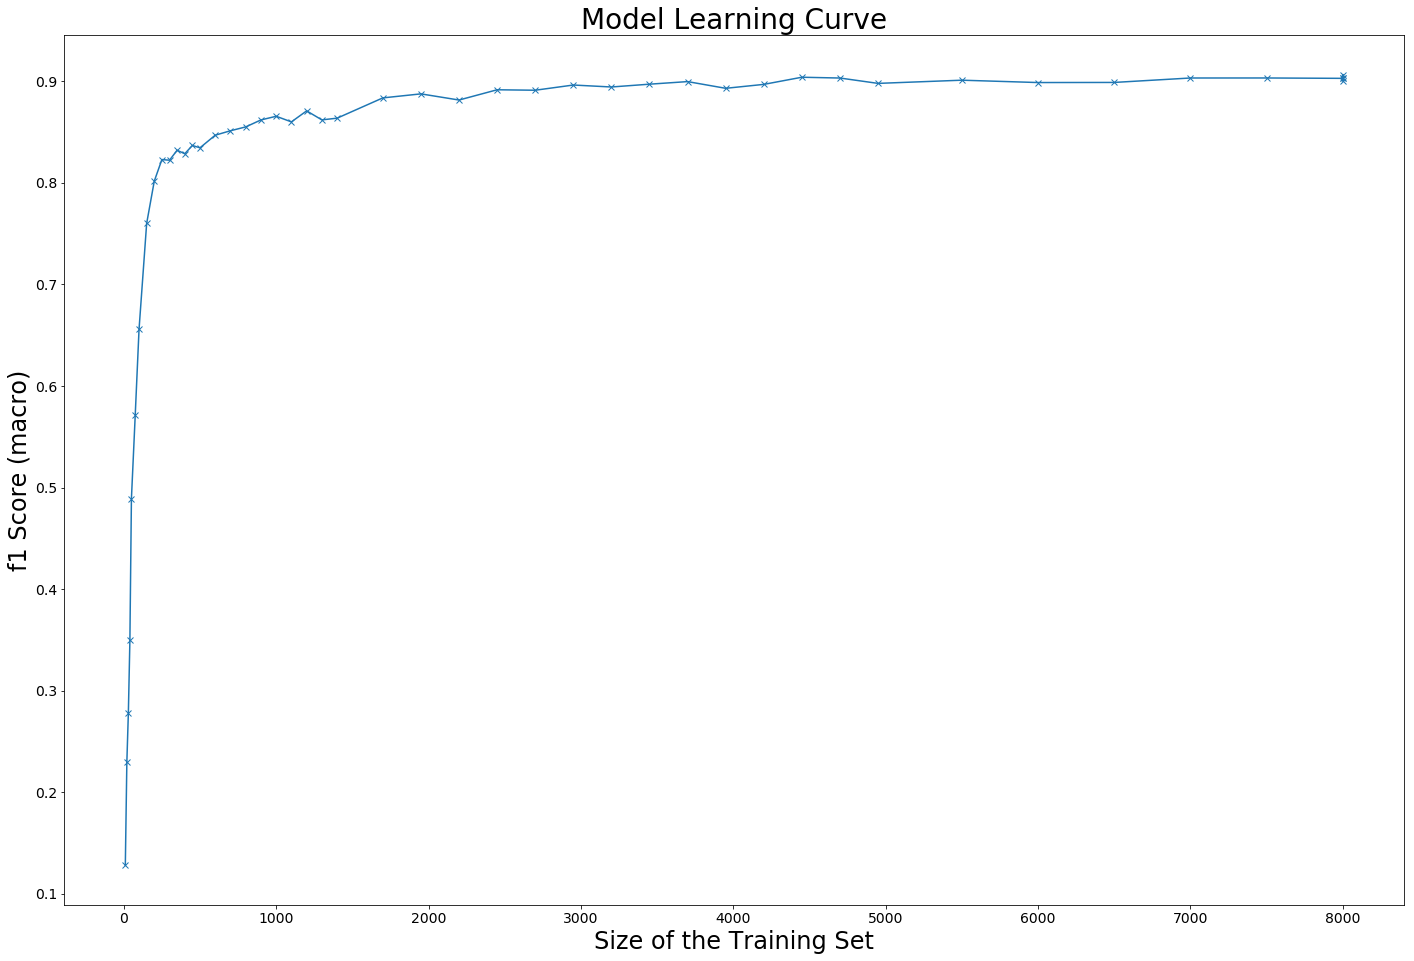

In [49]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]

plt.plot(num_labels, f1, '-x')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')

We see that the performance of our classifier greatly improve when we add more labeled instances to a small set.  
After ~350 labeled samples, increasing the size of the training set has a positive but much lower effect on model performance.

# Applying Active Learning

Let's compare this to an Active Learning algorithm:

In [21]:
df = pd.DataFrame([[item] for item in X_train], columns=['X'])
df['y'] = y_train
print(df.shape)
df.head()

(8000, 2)


,X,y
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


Train classifier on the first set of labeled data. We make this set larger than all other batches of updates, as we want to reduce the risk of biases. 

In [22]:
def run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1) # Get a random permutation of the dataframe
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        # select_next_batch_func() is a function we pass as a parameter. This allows us to set smart batch selection mechanisms
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        # Fit the model on instances that have a label
        model.fit(X_labeled, y=labeled['y'].values)

        # Predict probabilities of all instances (labeled + yet unlabeled)
        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        df['prediction'] = model.predict(X_all)

        # Save model performance
        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test, y_pred=model.predict(X_test)),
                        "f1": f1_score(y_true=y_test, y_pred=model.predict(X_test), average='macro')
                       })

    return al_history

We wrote code in a way that allows us to use different functions for selecting the next batch.  

We will use a naive function that just returns instances that still weren't labeled, and have the lowest confidence.  
This is actually pretty risky - we might get stuck with under-represented classes, and get shifted away to specific type of errors.  
Good functions take into account the 

In [23]:
def select_next_batch_func(df, batch_size):
    df = df.sort_values(by=['used','confidence'], ascending=[True,True])
    next_labels = df[:batch_size]
    return next_labels

In [24]:
num_samples_in_active_learning_batch = [100] + [25]*100
al_history = run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func)

fitting a model for 100 labeled instances...
fitting a model for 125 labeled instances...
fitting a model for 150 labeled instances...
fitting a model for 175 labeled instances...
fitting a model for 200 labeled instances...
fitting a model for 225 labeled instances...
fitting a model for 250 labeled instances...
fitting a model for 275 labeled instances...
fitting a model for 300 labeled instances...
fitting a model for 325 labeled instances...
fitting a model for 350 labeled instances...
fitting a model for 375 labeled instances...
fitting a model for 400 labeled instances...
fitting a model for 425 labeled instances...
fitting a model for 450 labeled instances...
fitting a model for 475 labeled instances...
fitting a model for 500 labeled instances...
fitting a model for 525 labeled instances...
fitting a model for 550 labeled instances...
fitting a model for 575 labeled instances...
fitting a model for 600 labeled instances...
fitting a model for 625 labeled instances...
fitting a 

Now, let's fit the results of our Active Learner together with those of the basic model:

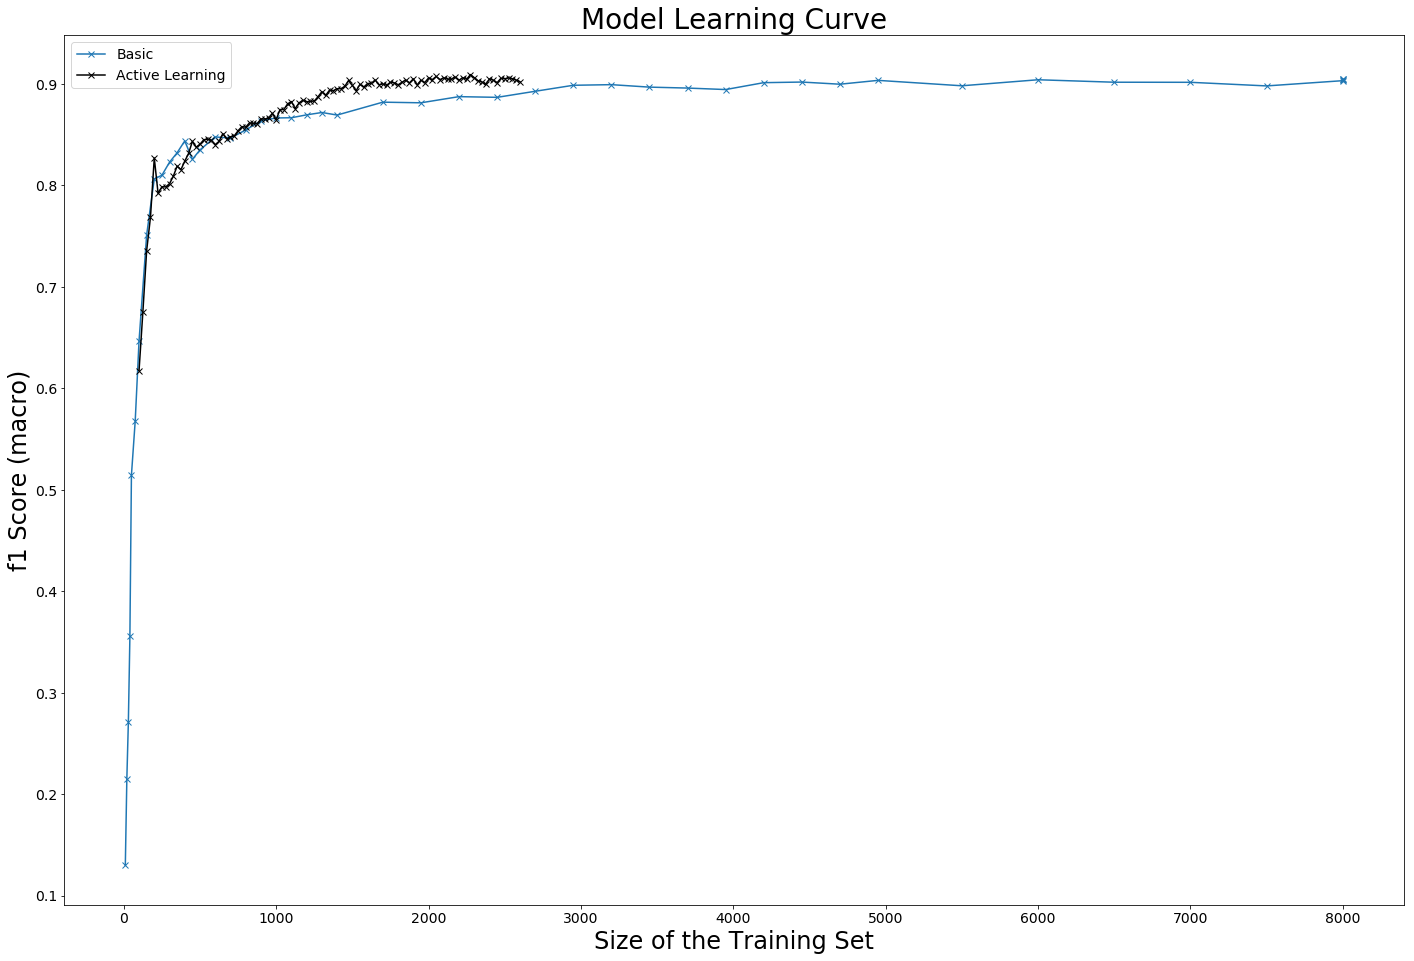

In [27]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]

plt.plot(num_labels, f1, '-x')
plt.plot([v['num_labeled'] for v in al_history], [v['f1'] for v in al_history], '-xk')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')
plt.legend(['Basic', 'Active Learning'])

We can see the our Active Learning model got better results over, using a much smaller dataset!

Next, let's check if the observations we asked to label based on the confidence of the Logistic Regression model are helpful for other models. We'll train a SVM model with a Radial Basis Function.  
We'll plot its learning curve for randomly selected samples along with the learning curve for observations that were chosen for labeling in our previous Logistic Regression classifier.

In [43]:
def run_active_learner_with_different_model(df, model, model2, num_samples_in_active_learning_batch, select_next_batch_func):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1) # Get a random permutation of the dataframe
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        # select_next_batch_func() is a function we pass as a parameter. This allows us to set smart batch selection mechanisms
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        # Fit the model on instances that have a label
        model.fit(X_labeled, y=labeled['y'].values)
        model2.fit(X_labeled, y=labeled['y'].values)

        # Predict probabilities of all instances (labeled + yet unlabeled)
        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        df['prediction'] = model.predict(X_all)

        # Save model performance
        pred_test = model.predict(X_test)
        model2_pred_test = model2.predict(X_test)
        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test, y_pred=pred_test),
                        "f1": f1_score(y_true=y_test, y_pred=pred_test, average='macro'),
                        "accuracy_model2": accuracy_score(y_true=y_test, y_pred=model2_pred_test),
                        "f1_model2": f1_score(y_true=y_test, y_pred=model2_pred_test, average='macro')
                       })

    return al_history

In [44]:
from sklearn import svm
model2 = svm.SVC(kernel='rbf', class_weight='balanced')
num_samples_in_active_learning_batch = [200] + [40]*50

al_history_model2 = run_active_learner_with_different_model(df, model, model2, num_samples_in_active_learning_batch, select_next_batch_func)

fitting a model for 200 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 240 labeled instances...
fitting a model for 280 labeled instances...
fitting a model for 320 labeled instances...
fitting a model for 360 labeled instances...
fitting a model for 400 labeled instances...
fitting a model for 440 labeled instances...
fitting a model for 480 labeled instances...
fitting a model for 520 labeled instances...
fitting a model for 560 labeled instances...
fitting a model for 600 labeled instances...
fitting a model for 640 labeled instances...
fitting a model for 680 labeled instances...
fitting a model for 720 labeled instances...
fitting a model for 760 labeled instances...
fitting a model for 800 labeled instances...
fitting a model for 840 labeled instances...
fitting a model for 880 labeled instances...
fitting a model for 920 labeled instances...
fitting a model for 960 labeled instances...
fitting a model for 1000 labeled instances...
fitting a model for 1040 labeled instances...
fitting a model for 1080 labeled instances...
fitting

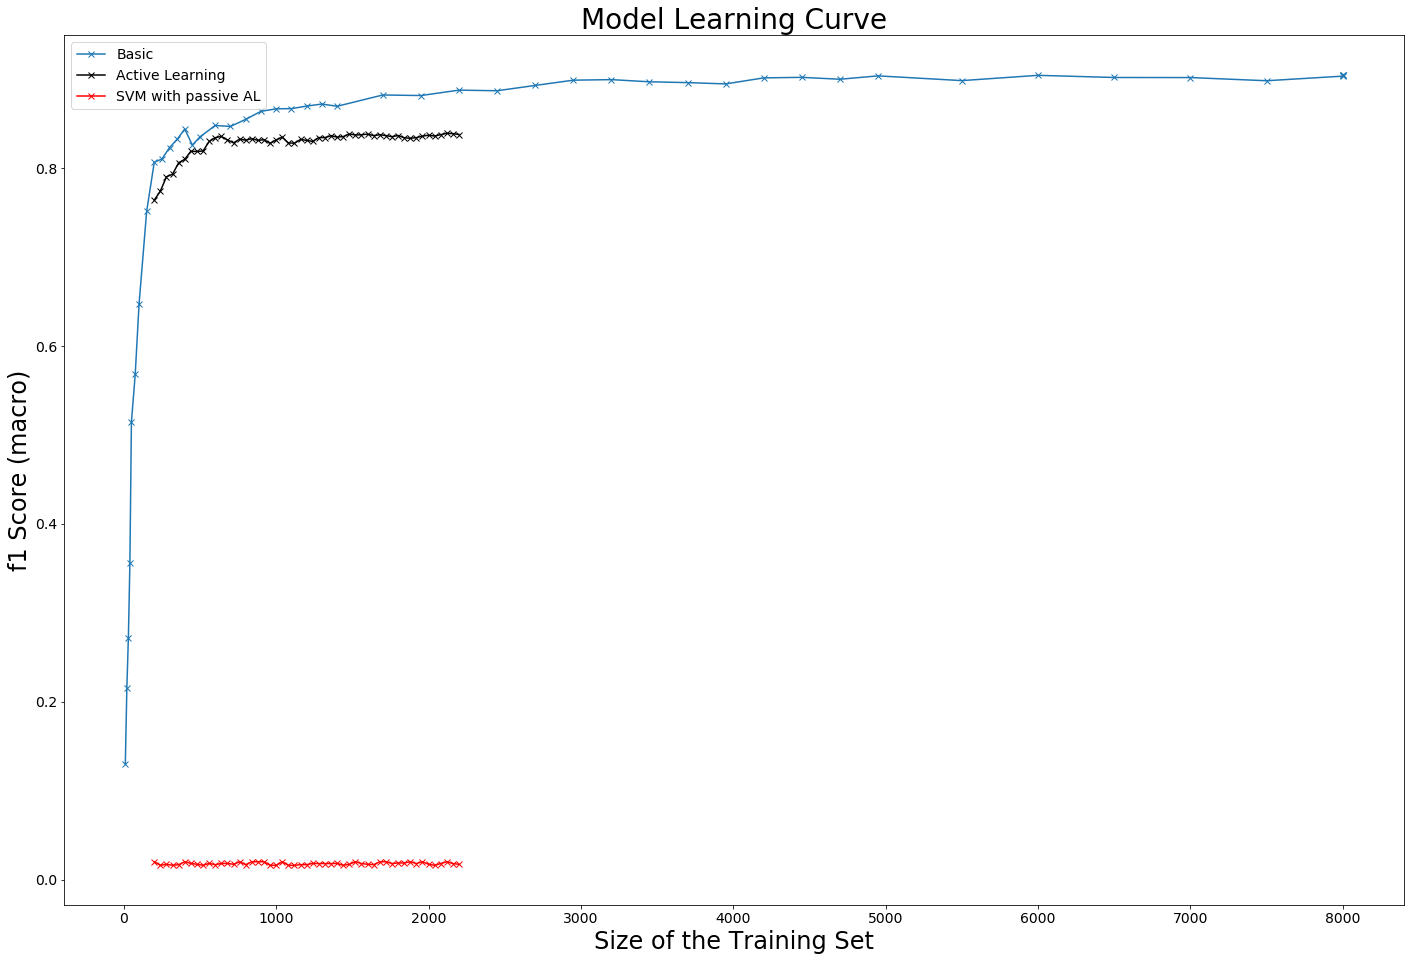

In [45]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]

plt.plot(num_labels, f1, '-x')
plt.plot([v['num_labeled'] for v in al_history_model2], [v['f1'] for v in al_history_model2], '-xk')
plt.plot([v['num_labeled'] for v in al_history_model2], [v['f1_model2'] for v in al_history_model2], '-xr')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')
plt.legend(['Basic', 'Active Learning', 'SVM with passive AL'])

In [46]:
al_history_model2[-1]

{'accuracy': 0.8415,
 'accuracy_model2': 0.0945,
 'f1': 0.8376073590473927,
 'f1_model2': 0.01726815897670169,
 'labeled':                                                       X  confidence  \
 438   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 1000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 5783  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 7039  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 3496  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 3545  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 1050  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 4791  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 2579  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 5638  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
 5002  [0, 0, 